学习{mlr3verse}非顺序管道与调优

In [1]:
library(mlr3verse)
library(tidyverse)

Loading required package: mlr3

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
library(mlr3pipelines)

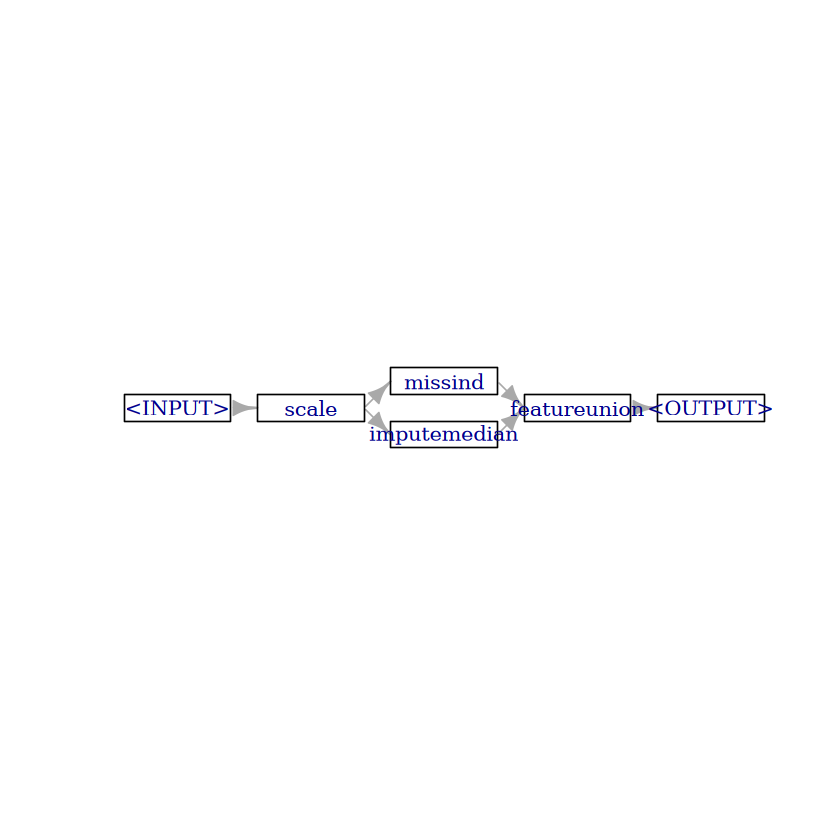

In [3]:
graph <- po("scale", center = TRUE, scale = FALSE) %>>%
  gunion(list(
    po("missind"),
    po("imputemedian")
  )) %>>%
  po("featureunion")

graph$plot(horiz = TRUE)

In [5]:
library(mlr3verse)

Loading required package: mlr3



In [ ]:
tsk_pima_head <- tsk("pima")$filter(1:3)
tsk_pima_head$data(cols = c("diabetes", "insulin", "triceps"))

# diabetes insulin triceps
# 1 pos      NA      35     
# 2 neg      NA      29     
# 3 pos      NA      NA

diabetes,insulin,triceps
<fct>,<dbl>,<dbl>
pos,NA,35
neg,NA,29
pos,NA,NA


In [ ]:
result <- graph$train(tsk_pima_head)[[1]]
result$data(
  cols = c("diabetes", "insulin", "missing_insulin",
           "triceps", "missing_triceps")
)

# diabetes insulin missing_insulin triceps missing_triceps
# 1 pos      0       missing          3      present        
# 2 neg      0       missing         -3      present        
# 3 pos      0       missing          0      missing

diabetes,insulin,missing_insulin,triceps,missing_triceps
<fct>,<dbl>,<fct>,<dbl>,<fct>
pos,0,missing,3,present
neg,0,missing,-3,present
pos,0,missing,0,missing


# 选择器与并行管道

In [ ]:
sel_bill <- selector_grep("^bill")
sel_not_bill <- selector_invert(sel_bill)

graph <- po("scale", affect_columns = sel_not_bill) %>>%
  po("pca", affect_columns = sel_bill)

result <- graph$train(tsk("penguins_simple"))
result[[1]]$data()[1:3, 1:5]

# species PC1       PC2        body_mass  flipper_length
# 1 Adelie  -5.014734  1.0716828 -0.5676206 -1.4246077    
# 2 Adelie  -4.495124 -0.1852998 -0.5055254 -1.0678666    
# 3 Adelie  -3.754628  0.4867612 -1.1885721 -0.4257325

species,PC1,PC2,body_mass,flipper_length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Adelie,-5.014734,1.0716828,-0.5676206,-1.4246077
Adelie,-4.495124,-0.1852998,-0.5055254,-1.0678666
Adelie,-3.754628,0.4867612,-1.1885721,-0.4257325


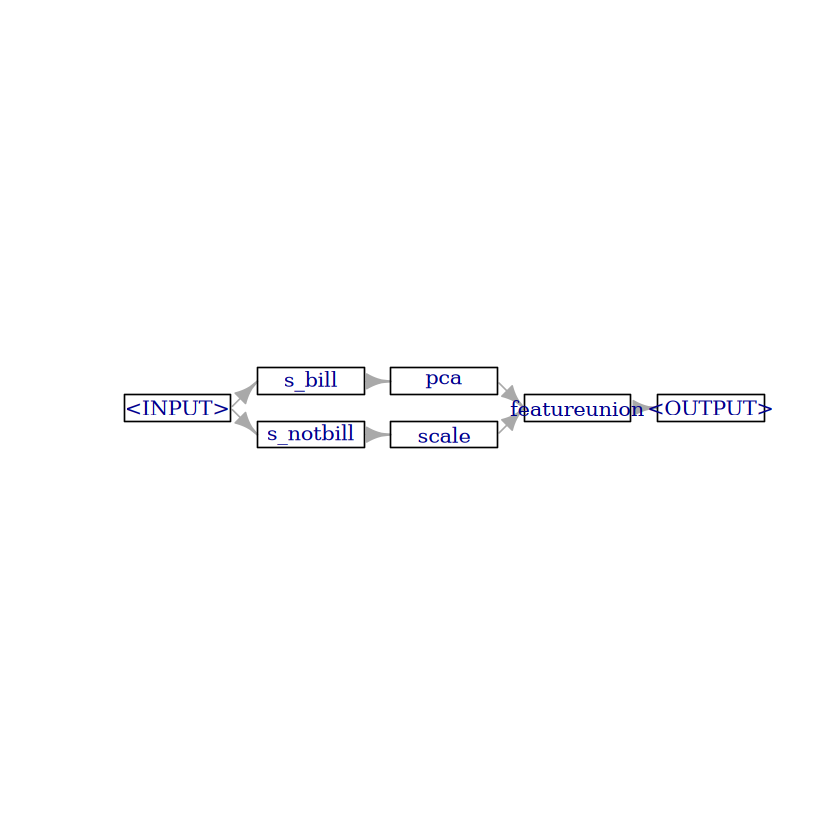

In [9]:
po_select_bill <- po("select", id = "s_bill", selector = sel_bill)
po_select_not_bill <- po(
  "select",
  id = "s_notbill",
  selector = sel_not_bill
)

path_pca <- po_select_bill %>>% po("pca")
path_scale <- po_select_not_bill %>>% po("scale")

graph <- gunion(list(path_pca, path_scale)) %>>% po("featureunion")
graph$plot(horizontal = TRUE)

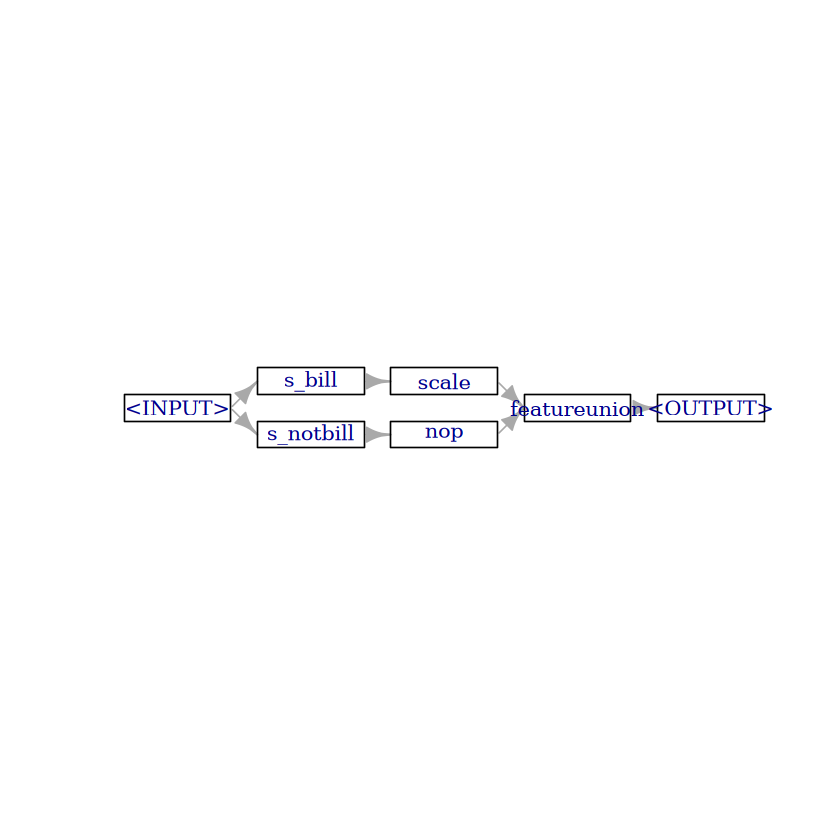

In [10]:
graph <- gunion(list(
  po_select_bill %>>% po("scale"),
  po_select_not_bill %>>% po("nop")
)) %>>% po("featureunion")
graph$plot(horizontal = TRUE)

In [ ]:
graph$train(tsk("penguins_simple"))[[1]]$data()[1:3, 1:5]

# species bill_depth bill_length body_mass flipper_length
# 1 Adelie  0.7795590  -0.8946955  3750      181           
# 2 Adelie  0.1194043  -0.8215515  3800      186           
# 3 Adelie  0.4240910  -0.6752636  3250      195

species,bill_depth,bill_length,body_mass,flipper_length
<fct>,<dbl>,<dbl>,<int>,<int>
Adelie,0.7795590,-0.8946955,3750,181
Adelie,0.1194043,-0.8215515,3800,186
Adelie,0.4240910,-0.6752636,3250,195


# 常见模式与 ppl()

In [ ]:
ppl()

# <DictionaryGraph> with 8 stored values
# Keys: bagging, branch, convert_types, greplicate, ovr, robustify,
#   stacking, targettrafo

<DictionaryGraph> with 8 stored values
Keys: bagging, branch, convert_types, greplicate, ovr, robustify,
  stacking, targettrafo

In [14]:
gr_single_pred <- po("subsample", frac = 0.7) %>>% lrn("classif.rpart")

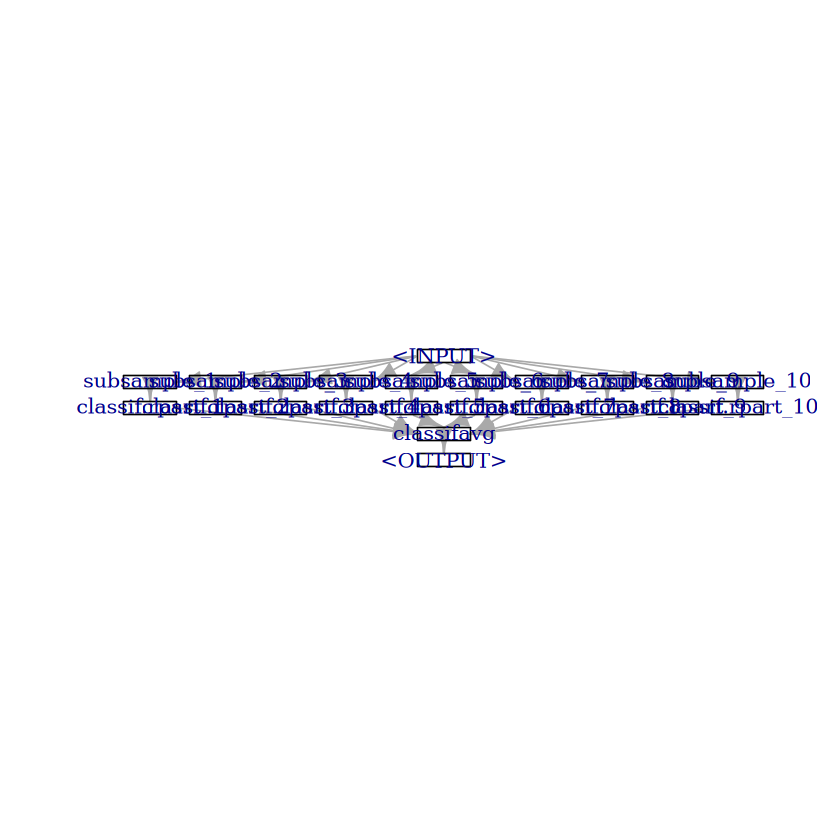

In [21]:
gr_pred_set <- ppl("greplicate", graph = gr_single_pred, n = 10)
gr_bagging <- gr_pred_set %>>% po("classifavg", innum = 10)
gr_bagging$plot()

In [ ]:
# 将图转为学习器
glrn_bagging <- as_learner(gr_bagging)
glrn_bagging$id <- "bagging"

lrn_rpart <- lrn("classif.rpart")
learners <- list(glrn_bagging, lrn_rpart, lrn("classif.ranger"))

bmr <- benchmark(
  benchmark_grid(
    tsk("sonar"),
    learners,
    rsmp("cv", folds = 3)
  )
)
bmr$aggregate()[, .(learner_id, classif.ce)]

# learner_id     classif.ce
# 1 bagging        0.2495514 
# 2 classif.rpart  0.3124224 
# 3 classif.ranger 0.1967564

INFO  [20:47:48.090] [mlr3] Running benchmark with 9 resampling iterations
INFO  [20:47:48.136] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 1/3)
INFO  [20:47:48.450] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 2/3)
INFO  [20:47:48.697] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 3/3)
INFO  [20:47:49.036] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/3)
INFO  [20:47:49.046] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/3)
INFO  [20:47:49.059] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/3)
INFO  [20:47:49.069] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/3)
INFO  [20:47:49.383] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 2/3)
INFO  [20:47:49.437] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 3/3)
INFO  [20:47:49.489] [mlr3] Finished benchmark


learner_id,classif.ce
<chr>,<dbl>
bagging,0.2495514
classif.rpart,0.3124224
classif.ranger,0.1967564


In [ ]:
ppl(
  "bagging",
  lrn("classif.rpart"),
  iterations = 10,
  frac = 0.7,
  averager = po("classifavg", collect_multiplicity = TRUE)
)

# Graph with 4 PipeOps:
#             ID         State      sccssors     prdcssors
#         <char>        <char>        <char>        <char>
#      replicate <<UNTRAINED>>     subsample              
#      subsample <<UNTRAINED>> classif.rpart     replicate
#  classif.rpart <<UNTRAINED>>    classifavg     subsample
#     classifavg <<UNTRAINED>>               classif.rpart

Graph with 4 PipeOps:
            ID         State      sccssors     prdcssors
        <char>        <char>        <char>        <char>
     replicate <<UNTRAINED>>     subsample              
     subsample <<UNTRAINED>> classif.rpart     replicate
 classif.rpart <<UNTRAINED>>    classifavg     subsample
    classifavg <<UNTRAINED>>               classif.rpart

In [ ]:
# custom selector
selector_subsample <- function(task) {
  sample(task$feature_names, sqrt(length(task$feature_names)))
}

# bagging pipeline with our selector
gr_bagging_quasi_rf <- ppl(
  "bagging",
  graph = po("select", selector = selector_subsample) %>>%
    lrn("classif.rpart", minsplit = 1),
  iterations = 100,
  averager = po("classifavg", collect_multiplicity = TRUE)
)

# bootstrap resampling
gr_bagging_quasi_rf$param_set$values$subsample.replace <- TRUE

# convert to learner
glrn_quasi_rf <- as_learner(gr_bagging_quasi_rf)
glrn_quasi_rf$id <- "quasi.rf"

# benchmark
design <- benchmark_grid(
  tsks("sonar"),
  c(glrn_quasi_rf, lrn("classif.ranger", num.trees = 100)),
  rsmp("cv", folds = 5)
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

# learner_id     classif.ce
# 1 quasi.rf       0.1875726 
# 2 classif.ranger 0.1922184

INFO  [20:51:08.180] [mlr3] Running benchmark with 10 resampling iterations
INFO  [20:51:08.187] [mlr3] Applying learner 'quasi.rf' on task 'sonar' (iter 1/5)
INFO  [20:51:11.333] [mlr3] Applying learner 'quasi.rf' on task 'sonar' (iter 2/5)
INFO  [20:51:14.269] [mlr3] Applying learner 'quasi.rf' on task 'sonar' (iter 3/5)
INFO  [20:51:16.506] [mlr3] Applying learner 'quasi.rf' on task 'sonar' (iter 4/5)
INFO  [20:51:19.158] [mlr3] Applying learner 'quasi.rf' on task 'sonar' (iter 5/5)
INFO  [20:51:21.691] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 1/5)
INFO  [20:51:21.710] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 2/5)
INFO  [20:51:21.727] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 3/5)
INFO  [20:51:21.744] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 4/5)
INFO  [20:51:21.762] [mlr3] Applying learner 'classif.ranger' on task 'sonar' (iter 5/5)
INFO  [20:51:21.779] [mlr3] Finished benchmark


learner_id,classif.ce
<chr>,<dbl>
quasi.rf,0.1875726
classif.ranger,0.1922184


## 手动实现bagging算法1

In [27]:
# 手动构建bagging学习器
g_single <- po("subsample", frac = 0.7) %>>% lrn("classif.rpart")
g_bagging <- ppl("greplicate", graph = g_single, n = 10) %>>%
  po("classifavg", innum = 10)
glrn_bagging <- as_learner(g_bagging)
glrn_bagging$id <- "bagging"

# 定义剩余学习器
lrn_rpart <- lrn("classif.rpart")
lrn_ranger <- lrn("classif.ranger")
lrns <- c(
  glrn_bagging,
  lrn_rpart,
  lrn_ranger
)

# 定义基准测试
design <- benchmark_grid(
  tsk("sonar"),
  lrns,
  rsmp("cv", folds = 5)
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

INFO  [21:13:34.045] [mlr3] Running benchmark with 15 resampling iterations
INFO  [21:13:34.050] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 1/5)
INFO  [21:13:34.337] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 2/5)
INFO  [21:13:34.601] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 3/5)
INFO  [21:13:34.829] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 4/5)
INFO  [21:13:35.073] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 5/5)
INFO  [21:13:35.429] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/5)
INFO  [21:13:35.439] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/5)
INFO  [21:13:35.450] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/5)
INFO  [21:13:35.460] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 4/5)
INFO  [21:13:35.470] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 5/5)
INFO  [21:13:35.480] [mlr3] Applying learner 'classif.ranger' on task 'son

learner_id,classif.ce
<chr>,<dbl>
bagging,0.2015099
classif.rpart,0.2499419
classif.ranger,0.1485482


## 手动实现bagging算法2

In [29]:
g_bagging <- ppl(
  "bagging",
  lrn("classif.rpart"),
  iterations = 10,
  frac = 0.7,
  averager = po("classifavg", collect_multiplicity = TRUE)
)

glrn_bagging <- as_learner(g_bagging)
glrn_bagging$id <- "bagging"

# 定义剩余学习器
lrn_rpart <- lrn("classif.rpart")
lrn_ranger <- lrn("classif.ranger")
lrns <- c(
  glrn_bagging,
  lrn_rpart,
  lrn_ranger
)

# 定义基准测试
design <- benchmark_grid(
  tsk("sonar"),
  lrns,
  rsmp("cv", folds = 5)
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

INFO  [21:18:38.344] [mlr3] Running benchmark with 15 resampling iterations
INFO  [21:18:38.350] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 1/5)
INFO  [21:18:38.683] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 2/5)
INFO  [21:18:38.881] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 3/5)
INFO  [21:18:39.097] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 4/5)
INFO  [21:18:39.293] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 5/5)
INFO  [21:18:39.536] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/5)
INFO  [21:18:39.547] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/5)
INFO  [21:18:39.559] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/5)
INFO  [21:18:39.571] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 4/5)
INFO  [21:18:39.584] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 5/5)
INFO  [21:18:39.596] [mlr3] Applying learner 'classif.ranger' on task 'son

learner_id,classif.ce
<chr>,<dbl>
bagging,0.2205575
classif.rpart,0.2691057
classif.ranger,0.1583043


## 手动实现随机森林

相较于bagging方法，随机森林方法的特征也是随机的，我们简单实现一下。

In [32]:
# 随机选择特征，和bagging的核心区别
selector_subsample <- function(task) {
  sample(task$feature_names, sqrt(length(task$feature_names)))
}

# 随机森林
g_bagging_rf <- ppl(
  "bagging",
  graph = po("select", selector = selector_subsample) %>>%
    lrn("classif.rpart"),
  iterations = 100,
  averager = po("classifavg", collect_multiplicity = TRUE)
)
g_bagging_rf$param_set$values$subsample.replace <- TRUE

# 普通的bagging
g_bagging <- ppl(
  "bagging",
  lrn("classif.rpart"),
  iterations = 100,
  averager = po("classifavg", collect_multiplicity = TRUE)
)

# 设置学习器
glrn_bagging <- as_learner(g_bagging)
glrn_bagging$id <- "bagging"
glrn_bagging_rf <- as_learner(g_bagging_rf)
glrn_bagging_rf$id <- "bagging_rf"

# 定义剩余学习器
lrn_rpart <- lrn("classif.rpart")
lrn_ranger <- lrn("classif.ranger")
lrns <- c(
  glrn_bagging,
  lrn_rpart,
  lrn_ranger,
  glrn_bagging_rf
)

# 定义基准测试
design <- benchmark_grid(
  tsk("sonar"),
  lrns,
  rsmp("cv", folds = 5)
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

INFO  [21:32:04.263] [mlr3] Running benchmark with 20 resampling iterations
INFO  [21:32:04.279] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 1/5)
INFO  [21:32:06.153] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 2/5)
INFO  [21:32:07.672] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 3/5)
INFO  [21:32:09.290] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 4/5)
INFO  [21:32:11.045] [mlr3] Applying learner 'bagging' on task 'sonar' (iter 5/5)
INFO  [21:32:12.847] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/5)
INFO  [21:32:12.865] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/5)
INFO  [21:32:12.878] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/5)
INFO  [21:32:12.888] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 4/5)
INFO  [21:32:12.898] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 5/5)
INFO  [21:32:12.908] [mlr3] Applying learner 'classif.ranger' on task 'son

learner_id,classif.ce
<chr>,<dbl>
bagging,0.2212544
classif.rpart,0.2259001
classif.ranger,0.1822300
bagging_rf,0.2017422


## 手动实现stacking算法

In [37]:
lrn_rpart <- lrn("classif.rpart", predict_type = "prob")
po_rpart_cv <- po(
  "learner_cv",
  learner = lrn_rpart,
  resampling.folds = 2,
  id = "rpart_cv"
)

lrn_knn <- lrn("classif.kknn", predict_type = "prob")
po_knn_cv <- po(
  "learner_cv",
  learner = lrn_knn,
  resampling.folds = 2,
  id = "knn_cv"
)

lrn_glmnet <- lrn("classif.glmnet", predict_type = "prob")
po_glmnet_cv <- po(
  "learner_cv",
  learner = lrn_glmnet,
  resampling.folds = 2,
  id = "glmnet_cv"
)

In [ ]:
gr_combined <- gunion(list(
  po_rpart_cv,
  po_knn_cv,
  po_glmnet_cv
)) %>>% po("featureunion")

gr_combined$train(tsk("sonar"))[[1]]$head()

# Class rpart_cv.prob.M rpart_cv.prob.R knn_cv.prob.M knn_cv.prob.R
# 1 R     0.6000000       0.40000000      0.1777281     0.8222719    
# 2 R     0.2500000       0.75000000      0.7013115     0.2986885    
# 3 R     0.1666667       0.83333333      0.4752868     0.5247132    
# 4 R     0.6000000       0.40000000      0.3170042     0.6829958    
# 5 R     0.9722222       0.02777778      0.5879795     0.4120205    
# 6 R     0.4000000       0.60000000      0.1126927     0.8873073    
#   glmnet_cv.prob.M glmnet_cv.prob.R
# 1 0.35599664       0.64400336      
# 2 0.26537340       0.73462660      
# 3 0.82683094       0.17316906      
# 4 0.07945826       0.92054174      
# 5 0.97356389       0.02643611      
# 6 0.02141440       0.97858560

INFO  [09:51:16.731] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/2)
INFO  [09:51:16.753] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/2)
INFO  [09:51:16.842] [mlr3] Applying learner 'classif.kknn' on task 'sonar' (iter 1/2)
INFO  [09:51:16.866] [mlr3] Applying learner 'classif.kknn' on task 'sonar' (iter 2/2)
INFO  [09:51:18.348] [mlr3] Applying learner 'classif.glmnet' on task 'sonar' (iter 1/2)
INFO  [09:51:18.382] [mlr3] Applying learner 'classif.glmnet' on task 'sonar' (iter 2/2)


Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnet_cv's $train()"
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnet_cv's $train()"


Class,rpart_cv.prob.M,rpart_cv.prob.R,knn_cv.prob.M,knn_cv.prob.R,glmnet_cv.prob.M,glmnet_cv.prob.R
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R,0.6000000,0.40000000,0.1777281,0.8222719,0.35599664,0.64400336
R,0.2500000,0.75000000,0.7013115,0.2986885,0.26537340,0.73462660
R,0.1666667,0.83333333,0.4752868,0.5247132,0.82683094,0.17316906
R,0.6000000,0.40000000,0.3170042,0.6829958,0.07945826,0.92054174
R,0.9722222,0.02777778,0.5879795,0.4120205,0.97356389,0.02643611
R,0.4000000,0.60000000,0.1126927,0.8873073,0.02141440,0.97858560


In [41]:
gr_stack <- gr_combined %>>%
  po("select", selector = selector_grep("\\.M$"))

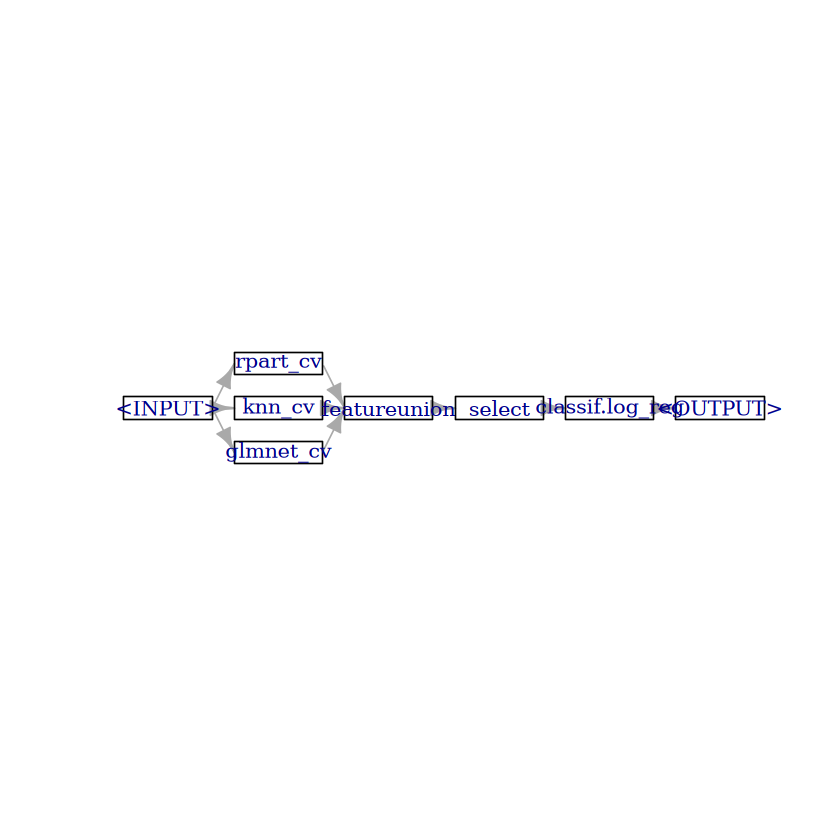

In [42]:
gr_stack <- gr_stack %>>% po("learner", lrn("classif.log_reg"))
gr_stack$plot(horizontal = TRUE)

In [ ]:
glrn_stack <- as_learner(gr_stack)
glrn_stack$train(tsk("sonar"))
glrn_stack$base_learner()$model

# Call:  stats::glm(formula = form, family = "binomial", data = data, 
#     model = FALSE)

# Coefficients:
#      (Intercept)   rpart_cv.prob.M     knn_cv.prob.M  glmnet_cv.prob.M  
#           -4.122             0.434             4.767             2.066  

# Degrees of Freedom: 207 Total (i.e. Null);  204 Residual
# Null Deviance:	    287.4 
# Residual Deviance: 148.6 	AIC: 156.6

INFO  [09:55:50.834] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/2)
INFO  [09:55:50.859] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/2)
INFO  [09:55:50.928] [mlr3] Applying learner 'classif.kknn' on task 'sonar' (iter 1/2)
INFO  [09:55:50.944] [mlr3] Applying learner 'classif.kknn' on task 'sonar' (iter 2/2)
INFO  [09:55:51.165] [mlr3] Applying learner 'classif.glmnet' on task 'sonar' (iter 1/2)
INFO  [09:55:51.184] [mlr3] Applying learner 'classif.glmnet' on task 'sonar' (iter 2/2)


Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnet_cv's $train()"
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's').
This happened PipeOp glmnet_cv's $train()"



Call:  stats::glm(formula = form, family = "binomial", data = data, 
    model = FALSE)

Coefficients:
     (Intercept)   rpart_cv.prob.M     knn_cv.prob.M  glmnet_cv.prob.M  
          -4.122             0.434             4.767             2.066  

Degrees of Freedom: 207 Total (i.e. Null);  204 Residual
Null Deviance:	    287.4 
Residual Deviance: 148.6 	AIC: 156.6

In [ ]:
glrn_stack$id <- "stacking"
design <- benchmark_grid(
  tsk("sonar"),
  list(lrn_rpart, lrn_knn, lrn_glmnet, glrn_stack),
  rsmp("repeated_cv")
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

# learner_id     classif.ce
# 1 classif.rpart  0.2830476 
# 2 classif.kknn   0.1530714 
# 3 classif.glmnet 0.2503810 
# 4 stacking       0.1351667

INFO  [09:57:18.135] [mlr3] Running benchmark with 400 resampling iterations
INFO  [09:57:18.146] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/100)
INFO  [09:57:18.165] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/100)
INFO  [09:57:18.181] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/100)
INFO  [09:57:18.197] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 4/100)
INFO  [09:57:18.211] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 5/100)
INFO  [09:57:18.229] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 6/100)
INFO  [09:57:18.792] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 7/100)
INFO  [09:57:18.803] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 8/100)
INFO  [09:57:18.813] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 9/100)
INFO  [09:57:18.824] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 10/100)
INFO  [09:57:18.834] [

Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda wi

INFO  [09:58:05.506] [mlr3] Finished benchmark


learner_id,classif.ce
<chr>,<dbl>
classif.rpart,0.2830476
classif.kknn,0.1530714
classif.glmnet,0.2503810
stacking,0.1351667


In [47]:
gr_stack <- ppl(
  "stacking",
  base_learners = lrns(
    c("classif.rpart", "classif.kknn", "classif.glmnet")
  ),
  super_learner = lrn("classif.log_reg")
)

lrn_stack <- as_learner(gr_stack)
lrn_stack$id <- "stacking"

# 基准测试
design <- benchmark_grid(
  tsk("sonar"),
  list(lrn_rpart, lrn_knn, lrn_glmnet, lrn_stack),
  rsmp("repeated_cv")
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

# learner_id     classif.ce
# 1 classif.rpart  0.2882619 
# 2 classif.kknn   0.1489048 
# 3 classif.glmnet 0.2501905 
# 4 stacking       0.2362619

INFO  [10:05:27.594] [mlr3] Running benchmark with 400 resampling iterations
INFO  [10:05:27.620] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 1/100)
INFO  [10:05:27.661] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 2/100)
INFO  [10:05:27.719] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 3/100)
INFO  [10:05:27.742] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 4/100)
INFO  [10:05:27.762] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 5/100)
INFO  [10:05:27.781] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 6/100)
INFO  [10:05:27.795] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 7/100)
INFO  [10:05:27.815] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 8/100)
INFO  [10:05:27.827] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 9/100)
INFO  [10:05:27.839] [mlr3] Applying learner 'classif.rpart' on task 'sonar' (iter 10/100)
INFO  [10:05:27.851] [

Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda will be set to 0.01 (see parameter 's')."
Warning message in glmnet_get_lambda(self, pv):
"Multiple lambdas have been fit. Lambda wi

INFO  [10:06:30.158] [mlr3] Finished benchmark


learner_id,classif.ce
<chr>,<dbl>
classif.rpart,0.2797857
classif.kknn,0.1550476
classif.glmnet,0.2559286
stacking,0.2451905


# 调优图

## 图超参数调优

In [48]:
glrn <- as_learner(po("pca") %>>% lrn("classif.kknn"))

In [ ]:
lrn_knn <- lrn("classif.kknn", k = to_tune(1, 32))
po_pca <- po("pca", rank. = to_tune(2, 20))
glrn <- as_learner(po_pca %>>% lrn_knn)
glrn$param_set$values

# $pca.rank.
# Tuning over:
# range [2, 20]


# $classif.kknn.k
# Tuning over:
# range [1, 32]

$pca.rank.
Tuning over:
range [2, 20]


$classif.kknn.k
Tuning over:
range [1, 32]



In [ ]:
glrn_tuned <- auto_tuner(
  tuner = tnr("random_search"),
  learner = glrn,
  resampling = rsmp("holdout"),
  terminator = trm("evals", n_evals = 10),
)

glrn_untuned <- po("pca") %>>% lrn("classif.kknn")

design <- benchmark_grid(
  tsk("sonar"),
  list(glrn_tuned, glrn_untuned),
  rsmp("cv", folds = 5)
)
bmr <- benchmark(design)
bmr$aggregate()[, .(learner_id, classif.ce)]

# learner_id             classif.ce
# 1 pca.classif.kknn.tuned 0.2063879 
# 2 pca.classif.kknn       0.2644599

INFO  [14:04:11.651] [mlr3] Running benchmark with 10 resampling iterations
INFO  [14:04:11.665] [mlr3] Applying learner 'pca.classif.kknn.tuned' on task 'sonar' (iter 1/5)
INFO  [14:04:11.837] [bbotk] Starting to optimize 2 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [14:04:11.868] [bbotk] Evaluating 1 configuration(s)
INFO  [14:04:11.874] [mlr3] Running benchmark with 1 resampling iterations
INFO  [14:04:11.879] [mlr3] Applying learner 'pca.classif.kknn' on task 'sonar' (iter 1/1)
INFO  [14:04:11.959] [mlr3] Finished benchmark
INFO  [14:04:11.977] [bbotk] Result of batch 1:
INFO  [14:04:11.981] [bbotk]  pca.rank. classif.kknn.k classif.ce warnings errors runtime_learners
INFO  [14:04:11.981] [bbotk]         14              7  0.2181818        0      0            0.075
INFO  [14:04:11.981] [bbotk]                                 uhash
INFO  [14:04:11.981] [bbotk]  64563b02-9bbc-446b-9920-78c7b9259c49
INFO  [14:04:11.988] [bbotk] Eva

learner_id,classif.ce
<chr>,<dbl>
pca.classif.kknn.tuned,0.2063879
pca.classif.kknn,0.2644599


## 使用 po("branch")调整替代路径

In [59]:
library(mlr3verse)

In [ ]:
library(mlr3oml)
otsk_mnist <- otsk(id = 3573)
tsk_mnist <- as_task(otsk_mnist)$
  filter(sample(70000, 1000))$
  select(otsk_mnist$feature_names[sample(700, 100)])

INFO  [14:21:30.854] Retrieving JSON {url: `https://www.openml.org/api/v1/json/task/3573`, authenticated: `FALSE`}
INFO  [14:21:32.046] Retrieving JSON {url: `https://www.openml.org/api/v1/json/data/554`, authenticated: `FALSE`}
INFO  [14:21:32.324] Retrieving JSON {url: `https://www.openml.org/api/v1/json/data/features/554`, authenticated: `FALSE`}
INFO  [14:21:33.580] Retrieving ARFF {url: `https://api.openml.org/data/v1/download/52667/mnist_784.arff`, authenticated: `FALSE`}


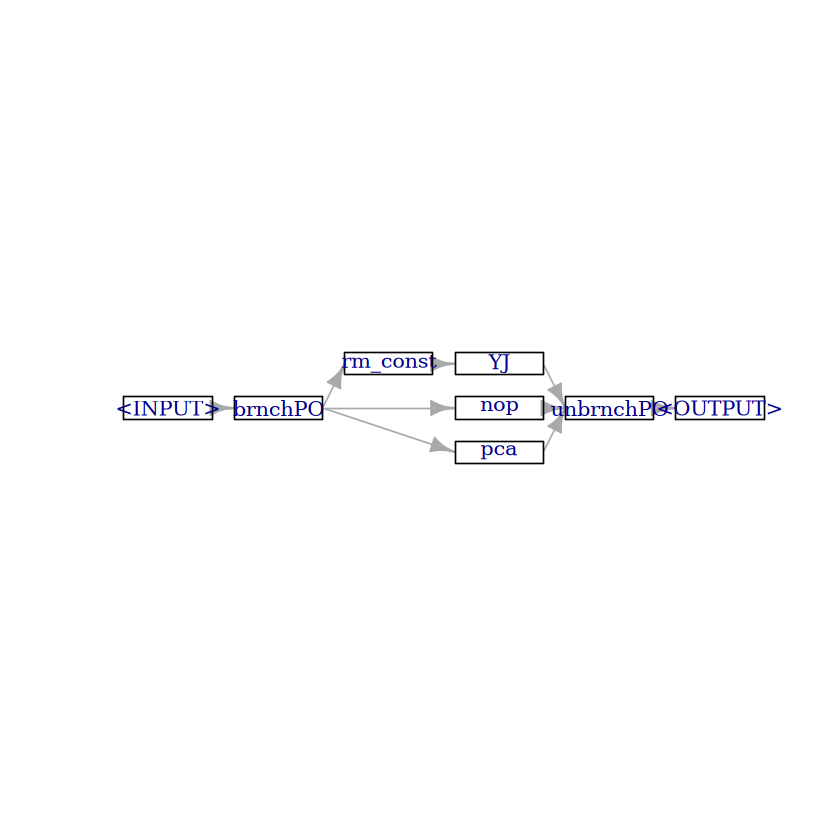

In [77]:
paths <- c("nop", "pca", "yeojohnson")

graph <- po("branch", options = paths, id = "brnchPO") %>>%
  gunion(list(
    po("nop"),
    po("pca"),
    po("removeconstants", id = "rm_const") %>>% po("yeojohnson", id = "YJ")
  )) %>>%
  po("unbranch", options = paths, id = "unbrnchPO")

graph$plot(horiz = TRUE)

In [80]:
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.2     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
graph$param_set$values$brnchPO.selection <- "pca"
graph$train(tsk_mnist)[[1]]$feature_names %>% head()

# [1] "PC1" "PC2" "PC3" "PC4" "PC5" "PC6"

[1] "PC1" "PC2" "PC3" "PC4" "PC5" "PC6"

In [ ]:
graph$param_set$values$brnchPO.selection <- "nop"
graph$train(tsk_mnist)[[1]]$feature_names %>% head()

# [1] "pixel6"  "pixel11" "pixel43" "pixel45" "pixel52" "pixel65"

[1] "pixel6"  "pixel11" "pixel43" "pixel45" "pixel52" "pixel65"

In [ ]:
ppl("branch", graphs = pos(c("nop", "pca", "yeojohnson")))

# Graph with 5 PipeOps:
#          ID         State           sccssors          prdcssors
#      <char>        <char>             <char>             <char>
#      branch <<UNTRAINED>> nop,pca,yeojohnson                   
#         nop <<UNTRAINED>>           unbranch             branch
#         pca <<UNTRAINED>>           unbranch             branch
#  yeojohnson <<UNTRAINED>>           unbranch             branch
#    unbranch <<UNTRAINED>>                    nop,pca,yeojohnson

Graph with 5 PipeOps:
         ID         State           sccssors          prdcssors
     <char>        <char>             <char>             <char>
     branch <<UNTRAINED>> nop,pca,yeojohnson                   
        nop <<UNTRAINED>>           unbranch             branch
        pca <<UNTRAINED>>           unbranch             branch
 yeojohnson <<UNTRAINED>>           unbranch             branch
   unbranch <<UNTRAINED>>                    nop,pca,yeojohnson

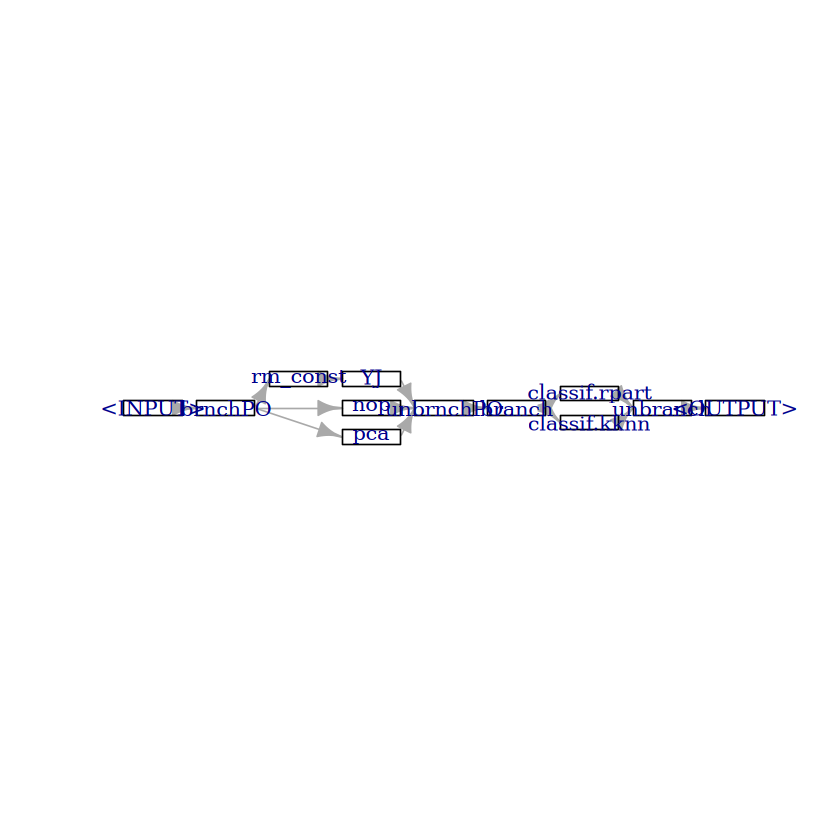

In [86]:
glrn <- graph %>>%
  ppl("branch", graphs = lrns(c("classif.rpart", "classif.kknn")))

glrn$plot(horiz = TRUE)

In [ ]:
glrn <- as_learner(glrn)

glrn$param_set$set_values(
  brnchPO.selection = to_tune(paths),
  branch.selection = to_tune(c("classif.rpart", "classif.kknn")),
  classif.kknn.k = to_tune(p_int(
    1, 32,
    depends = branch.selection == "classif.kknn"
  ))
)

instance <- tune(
  tuner = tnr("grid_search"),
  task = tsk_mnist,
  learner = glrn,
  resampling = rsmp("repeated_cv", folds = 3, repeats = 3),
  measure = msr("classif.ce")
)

instance$archive$data[
  order(classif.ce)[1:5],
  .(brnchPO.selection, classif.kknn.k, branch.selection, classif.ce)
]

# brnchPO.selection classif.kknn.k branch.selection classif.ce
# 1 nop               18             classif.kknn     0.2573252 
# 2 nop               11             classif.kknn     0.2573252 
# 3 nop               22             classif.kknn     0.2573262 
# 4 nop               15             classif.kknn     0.2583222 
# 5 nop                8             classif.kknn     0.2596579

INFO  [14:49:04.617] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorNone>'
INFO  [14:49:04.625] [bbotk] Evaluating 1 configuration(s)
INFO  [14:49:04.630] [mlr3] Running benchmark with 9 resampling iterations
INFO  [14:49:04.634] [mlr3] Applying learner 'brnchPO.nop.pca.rm_const.YJ.unbrnchPO.branch.classif.rpart.classif.kknn.unbranch' on task 'mnist_784' (iter 1/9)
INFO  [14:49:04.781] [mlr3] Applying learner 'brnchPO.nop.pca.rm_const.YJ.unbrnchPO.branch.classif.rpart.classif.kknn.unbranch' on task 'mnist_784' (iter 2/9)
INFO  [14:49:04.914] [mlr3] Applying learner 'brnchPO.nop.pca.rm_const.YJ.unbrnchPO.branch.classif.rpart.classif.kknn.unbranch' on task 'mnist_784' (iter 3/9)
INFO  [14:49:05.058] [mlr3] Applying learner 'brnchPO.nop.pca.rm_const.YJ.unbrnchPO.branch.classif.rpart.classif.kknn.unbranch' on task 'mnist_784' (iter 4/9)
INFO  [14:49:05.198] [mlr3] Applying learner 'brnchPO.nop.pca.rm_const.YJ.unbrnchPO.branch.classif.rpart.cla

brnchPO.selection,classif.kknn.k,branch.selection,classif.ce
<chr>,<int>,<chr>,<dbl>
nop,18,classif.kknn,0.2573252
nop,11,classif.kknn,0.2573252
nop,22,classif.kknn,0.2573262
nop,15,classif.kknn,0.2583222
nop,8,classif.kknn,0.2596579


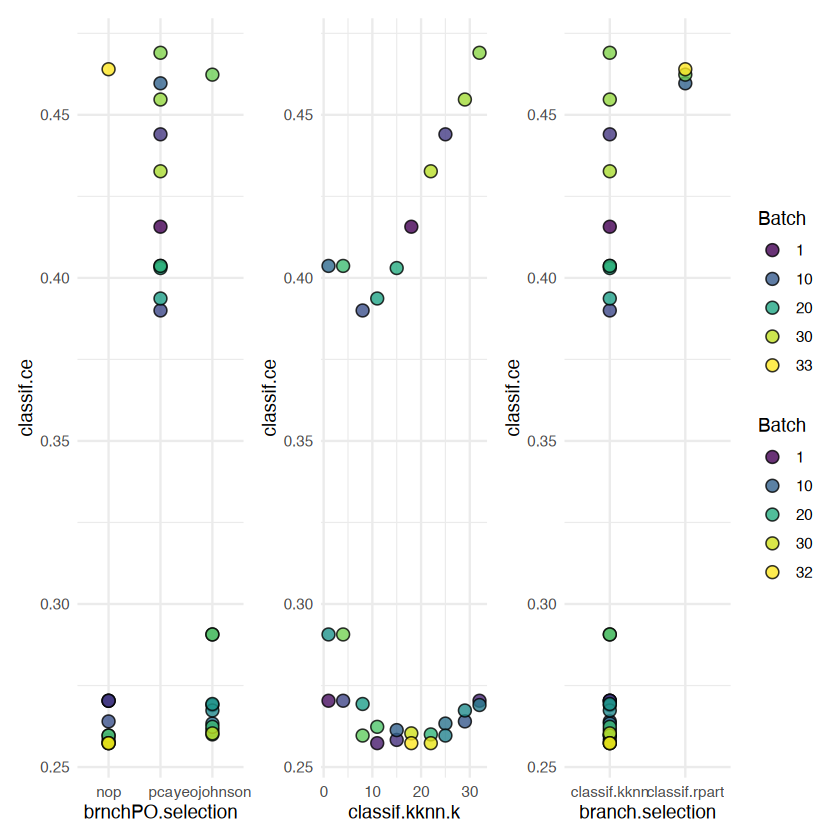

In [90]:
autoplot(instance)

## 使用 po("proxy")进行调参

In [91]:
glrn <- po("proxy", id = "preproc") %>>%
  po("proxy", id = "learner")

glrn <- as_learner(glrn)

In [93]:
preproc.content <- p_fct(
  list(
    nop = po("nop"),
    pca = po("pca"),
    yeojohnson = po("removeconstants") %>>% po("yeojohnson")
  )
)

In [94]:
# define content for the learner proxy operator
learner.content <- p_fct(list(
  classif.rpart = lrn("classif.rpart"),
  classif.kknn = lrn("classif.kknn")
))

# define transformation to set the content values
trafo <- function(x, param_set) {
  if (!is.null(x$classif.kknn.k)) {
    x$learner.content <- x$learner.content$clone(deep = TRUE)
    x$learner.content$param_set$values$k <- x$classif.kknn.k
    x$classif.kknn.k <- NULL
  }
  x
}

In [ ]:
search_space <- ps(
  preproc.content = preproc.content,
  learner.content = learner.content,
  # 正常调优KKNN参数
  classif.kknn.k = p_int(
    1, 32,
    depends = learner.content == "classif.kknn"
  ),
  .extra_trafo = trafo
)

instance <- tune(
  tuner = tnr("grid_search"),
  task = tsk_mnist,
  learner = glrn,
  resampling = rsmp("repeated_cv", folds = 3, repeats = 3),
  measure = msr("classif.ce"),
  search_space = search_space
)

as.data.table(instance$result)[,
  .(
    preproc.content,
    classif.kknn.k = x_domain[[1]]$learner.content$param_set$values$k,
    learner.content,
    classif.ce
  )
]

# preproc.content classif.kknn.k learner.content classif.ce
# 1 yeojohnson      18             classif.kknn    0.2589915

INFO  [15:06:38.482] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchGridSearch>' and '<TerminatorNone>'
INFO  [15:06:38.497] [bbotk] Evaluating 1 configuration(s)
INFO  [15:06:38.511] [mlr3] Running benchmark with 9 resampling iterations
INFO  [15:06:38.519] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 1/9)
INFO  [15:06:38.808] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 2/9)
INFO  [15:06:38.956] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 3/9)
INFO  [15:06:39.108] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 4/9)
INFO  [15:06:39.236] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 5/9)
INFO  [15:06:39.374] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 6/9)
INFO  [15:06:39.495] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (iter 7/9)
INFO  [15:06:39.631] [mlr3] Applying learner 'preproc.learner' on task 'mnist_784' (it

preproc.content,classif.kknn.k,learner.content,classif.ce
<chr>,<int>,<chr>,<dbl>
yeojohnson,18,classif.kknn,0.2589915


In [96]:
library(mlr3tuning)

learner <- lrn(
  "classif.svm",
  id = "svm",
  type = "C-classification",
  kernel = "radial",
  cost = to_tune(1e-5, 1e5, logscale = TRUE),
  gamma = to_tune(1e-5, 1e5, logscale = TRUE)
)

Loading required package: paradox



In [97]:
graph_learner <- as_learner(
  po("subsample", frac = to_tune(p_dbl(3^-3, 1, tags = "budget"))) %>>%
    learner
)

In [ ]:
graph_learner$encapsulate("evaluate", lrn("classif.featureless"))
graph_learner$timeout <- c(train = 30, predict = 30)

In [99]:
instance <- tune(
  tuner = tnr("hyperband", eta = 3),
  task = tsk("sonar"),
  learner = graph_learner,
  resampling = rsmp("cv", folds = 3),
  measure = msr("classif.ce")
)

INFO  [15:30:10.174] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerBatchHyperband>' and '<TerminatorNone>'
INFO  [15:30:10.186] [bbotk] Evaluating 27 configuration(s)
INFO  [15:30:10.211] [mlr3] Running benchmark with 81 resampling iterations
INFO  [15:30:10.216] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 1/3)
INFO  [15:30:10.300] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 138 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:10.324] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 2/3)
INFO  [15:30:10.353] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:10.382] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 3/3)
INFO  [15:30:10.402] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [15:30:14.838] [bbotk] Evaluating 21 configuration(s)
INFO  [15:30:15.010] [mlr3] Running benchmark with 63 resampling iterations
INFO  [15:30:15.024] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 1/3)
INFO  [15:30:15.122] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 138 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:15.229] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 2/3)
INFO  [15:30:15.314] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:15.354] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 3/3)
INFO  [15:30:15.391] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:15.448] [mlr3] Applying learn

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [15:30:18.672] [bbotk] Evaluating 13 configuration(s)
INFO  [15:30:18.684] [mlr3] Running benchmark with 39 resampling iterations
INFO  [15:30:18.687] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 1/3)
INFO  [15:30:18.723] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 138 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:18.751] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 2/3)
INFO  [15:30:18.771] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:18.791] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 3/3)
INFO  [15:30:18.816] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:18.841] [mlr3] Applying learn

Warning message in .__Codomain__maximization_to_minimization(self = self, private = private, :
"'maximization_to_minimization' is deprecated.
Use 'direction' instead.
See help("Deprecated")"


INFO  [15:30:20.208] [bbotk] Evaluating 8 configuration(s)
INFO  [15:30:20.215] [mlr3] Running benchmark with 24 resampling iterations
INFO  [15:30:20.219] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 1/3)
INFO  [15:30:20.242] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 138 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:20.261] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 2/3)
INFO  [15:30:20.280] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:20.299] [mlr3] Applying learner 'subsample.svm' on task 'sonar' (iter 3/3)
INFO  [15:30:20.318] [mlr3] Calling train method of fallback 'classif.featureless' on task 'sonar' with 139 observations {learner: <LearnerClassifFeatureless/LearnerClassif/Learner/R6>}
INFO  [15:30:20.336] [mlr3] Applying learne

In [ ]:
instance$result_x_domain

# $subsample.frac
# [1] 1

# $svm.cost
# [1] 54.37505

# $svm.gamma
# [1] 0.01561247

$subsample.frac
[1] 1

$svm.cost
[1] 54.37505

$svm.gamma
[1] 0.01561247

## 使用过滤管道的特征选择

In [ ]:
task_pen <- tsk("penguins")

po_flt <- po("filter", filter = flt("information_gain"), filter.nfeat = 3)
graph <- po_flt %>>% lrn("classif.rpart")

po("filter", filter = flt("information_gain"), filter.nfeat = 3)$
  train(list(task_pen))[[1]]$feature_names

# [1] "bill_depth"     "bill_length"    "flipper_length"

[1] "bill_depth"     "bill_length"    "flipper_length"

In [ ]:
# 在1到特征总数之间调优
po_filter <- po("filter", filter = flt("information_gain"),
  filter.nfeat = to_tune(1, task_pen$ncol)
)

graph <- as_learner(po_filter %>>% po("learner", lrn("classif.rpart")))

instance <- tune(
  tuner = tnr("random_search"),
  task = task_pen,
  learner = graph,
  resampling = rsmp("cv", folds = 3),
  terminator = trm("evals", n_evals = 10)
)
instance$result

# information_gain.filter.nfeat learner_param_vals x_domain classif.ce
# 1 7                             0, 7               7        0.06971777

INFO  [15:39:55.043] [bbotk] Starting to optimize 1 parameter(s) with '<OptimizerBatchRandomSearch>' and '<TerminatorEvals> [n_evals=10, k=0]'
INFO  [15:39:55.053] [bbotk] Evaluating 1 configuration(s)
INFO  [15:39:55.060] [mlr3] Running benchmark with 3 resampling iterations
INFO  [15:39:55.067] [mlr3] Applying learner 'information_gain.classif.rpart' on task 'penguins' (iter 1/3)
INFO  [15:39:55.113] [mlr3] Applying learner 'information_gain.classif.rpart' on task 'penguins' (iter 2/3)
INFO  [15:39:55.161] [mlr3] Applying learner 'information_gain.classif.rpart' on task 'penguins' (iter 3/3)
INFO  [15:39:55.199] [mlr3] Finished benchmark
INFO  [15:39:55.218] [bbotk] Result of batch 1:
INFO  [15:39:55.219] [bbotk]  information_gain.filter.nfeat classif.ce warnings errors runtime_learners
INFO  [15:39:55.219] [bbotk]                              7 0.06971777        0      0            0.105
INFO  [15:39:55.219] [bbotk]                                 uhash
INFO  [15:39:55.219] [bbotk] 

information_gain.filter.nfeat,learner_param_vals,x_domain,classif.ce
<int>,<list>,<list>,<dbl>
7,"0, 7",7,0.06971777


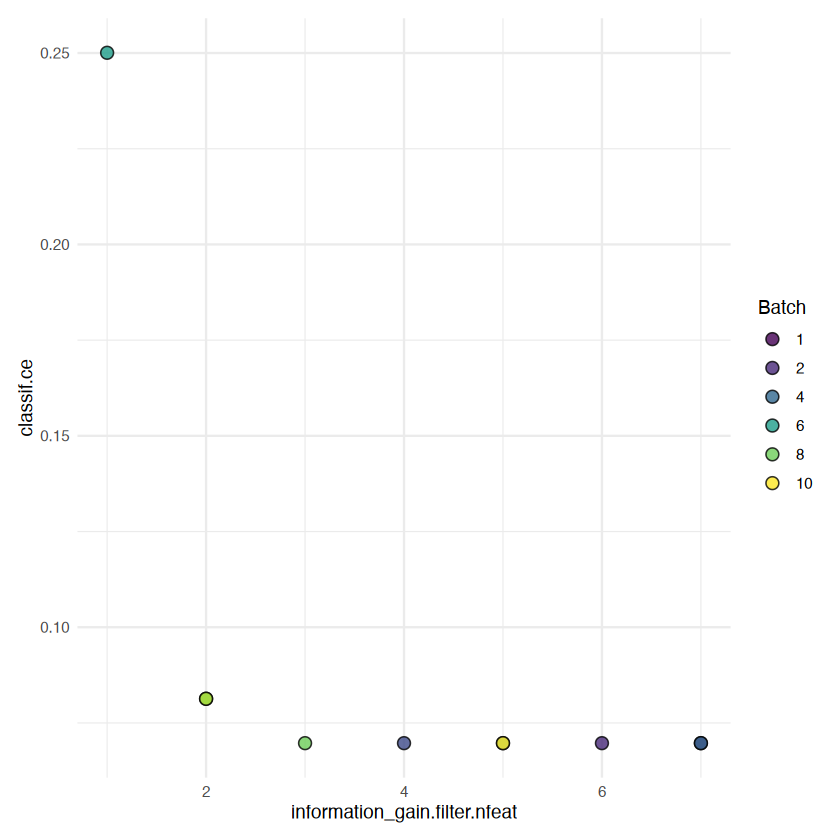

In [105]:
autoplot(instance)

# 练习

## 练习1

In [ ]:
tsk_pima <- tsk("pima")

po_pca <- po("pca", affect_columns = selector_invert(selector_missing()))

result <- po_pca$train(list(tsk_pima))

result[[1]]$data() %>% head()

# diabetes PC1         PC2        PC3        glucose insulin mass pressure
# 1 pos      -16.8863260 -0.6077147 -0.1358763 148      NA     33.6 72      
# 2 neg        2.6749164 -2.4406011  0.1370717  85      NA     26.6 66      
# 3 pos        0.5465899  4.3000334 -0.2332181 183      NA     23.3 64      
# 4 neg       12.5412307 -0.8086987  0.3001441  89      94     28.1 66      
# 5 pos        0.8630676 -3.7679822 -1.7883458 137     168     43.1 40      
# 6 neg        3.0094147  1.6699414  0.2556086 116      NA     25.6 74      
#   triceps
# 1 35     
# 2 29     
# 3 NA     
# 4 23     
# 5 35     
# 6 NA

diabetes,PC1,PC2,PC3,glucose,insulin,mass,pressure,triceps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pos,-16.8863260,-0.6077147,-0.1358763,148,NA,33.6,72,35
neg,2.6749164,-2.4406011,0.1370717,85,NA,26.6,66,29
pos,0.5465899,4.3000334,-0.2332181,183,NA,23.3,64,NA
neg,12.5412307,-0.8086987,0.3001441,89,94,28.1,66,23
pos,0.8630676,-3.7679822,-1.7883458,137,168,43.1,40,35
neg,3.0094147,1.6699414,0.2556086,116,NA,25.6,74,NA


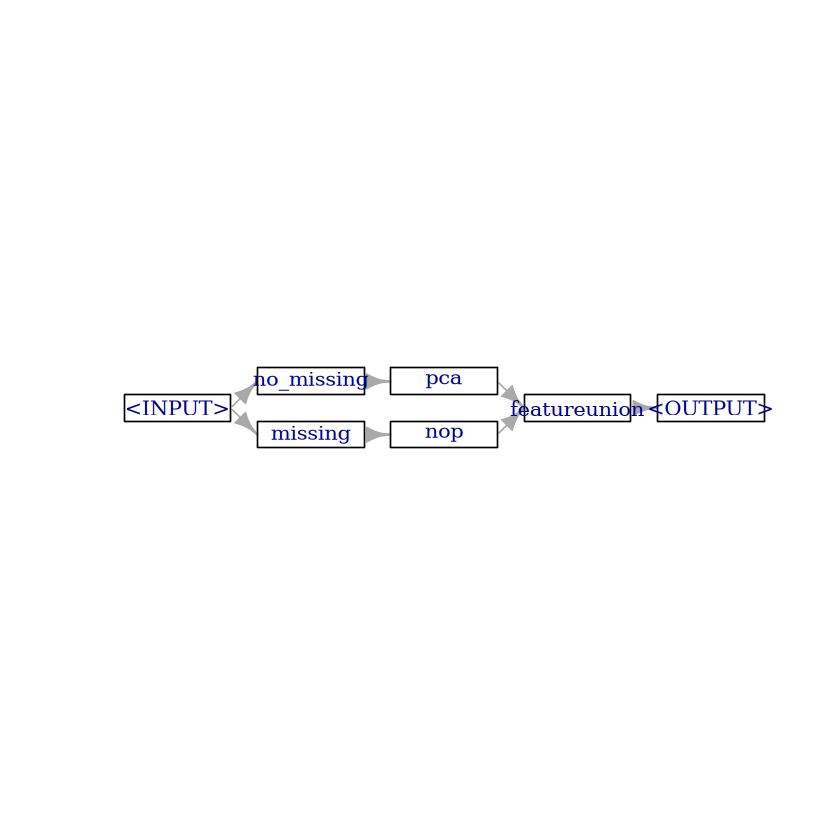

In [114]:
graph <- gunion(list(
  po(
    "select",
    selector = selector_invert(selector_missing()),
    id = "no_missing"
  ) %>>%
    po("pca"),
  po(
    "select",
    selector = selector_missing(),
    id = "missing"
  ) %>>%
    po("nop")
)) %>>%
  po("featureunion")
graph$plot(horiz = TRUE)

In [ ]:
result <- graph$train(tsk_pima)
result[[1]]$data() %>% head()

# diabetes PC1         PC2        PC3        glucose insulin mass pressure
# 1 pos      -16.8863260 -0.6077147 -0.1358763 148      NA     33.6 72      
# 2 neg        2.6749164 -2.4406011  0.1370717  85      NA     26.6 66      
# 3 pos        0.5465899  4.3000334 -0.2332181 183      NA     23.3 64      
# 4 neg       12.5412307 -0.8086987  0.3001441  89      94     28.1 66      
# 5 pos        0.8630676 -3.7679822 -1.7883458 137     168     43.1 40      
# 6 neg        3.0094147  1.6699414  0.2556086 116      NA     25.6 74      
#   triceps
# 1 35     
# 2 29     
# 3 NA     
# 4 23     
# 5 35     
# 6 NA

diabetes,PC1,PC2,PC3,glucose,insulin,mass,pressure,triceps
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pos,-16.8863260,-0.6077147,-0.1358763,148,NA,33.6,72,35
neg,2.6749164,-2.4406011,0.1370717,85,NA,26.6,66,29
pos,0.5465899,4.3000334,-0.2332181,183,NA,23.3,64,NA
neg,12.5412307,-0.8086987,0.3001441,89,94,28.1,66,23
pos,0.8630676,-3.7679822,-1.7883458,137,168,43.1,40,35
neg,3.0094147,1.6699414,0.2556086,116,NA,25.6,74,NA


In [ ]:
# 查看哪些列缺失
result[[1]]$data() %>%
  is.na() %>%
  apply(2, any)

# diabetes      PC1      PC2      PC3  glucose  insulin     mass pressure 
#    FALSE    FALSE    FALSE    FALSE     TRUE     TRUE     TRUE     TRUE 
#  triceps 
#     TRUE

diabetes      PC1      PC2      PC3  glucose  insulin     mass pressure 
   FALSE    FALSE    FALSE    FALSE     TRUE     TRUE     TRUE     TRUE 
 triceps 
    TRUE

## 练习2

In [124]:
tsk_wine <- tsk("wine")
tsk_wine$data() %>% glimpse()

Rows: 178
Columns: 14
$ type            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ alcalinity      <dbl> 15.6, 11.2, 18.6, 16.8, 21.0, 15.2, 14.6, 17.6, 14.0, ~
$ alcohol         <dbl> 14.23, 13.20, 13.16, 14.37, 13.24, 14.20, 14.39, 14.06~
$ ash             <dbl> 2.43, 2.14, 2.67, 2.50, 2.87, 2.45, 2.45, 2.61, 2.17, ~
$ color           <dbl> 5.64, 4.38, 5.68, 7.80, 4.32, 6.75, 5.25, 5.05, 5.20, ~
$ dilution        <dbl> 3.92, 3.40, 3.17, 3.45, 2.93, 2.85, 3.58, 3.58, 2.85, ~
$ flavanoids      <dbl> 3.06, 2.76, 3.24, 3.49, 2.69, 3.39, 2.52, 2.51, 2.98, ~
$ hue             <dbl> 1.04, 1.05, 1.03, 0.86, 1.04, 1.05, 1.02, 1.06, 1.08, ~
$ magnesium       <int> 127, 100, 101, 113, 118, 112, 96, 121, 97, 98, 105, 95~
$ malic           <dbl> 1.71, 1.78, 2.36, 1.95, 2.59, 1.76, 1.87, 2.15, 1.64, ~
$ nonflavanoids   <dbl> 0.28, 0.26, 0.30, 0.24, 0.39, 0.34, 0.30, 0.31, 0.29, ~
$ phenols         <dbl> 2.80, 2.65, 2.80, 3.85, 2.80, 3.27, 2.50, 2.60, 2.80, ~
$ proanthocyanins 